<a href="https://colab.research.google.com/github/a-woodbury/RxID/blob/master/RxID15_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Environment Prep

### Package Import

In [0]:
! pip install yellowbrick # not installed with colab by default

In [0]:
import os
import sys

#standard imports
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#for any image manipulation
import imageio
import imgaug as ia
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import scipy
from PIL import Image
from scipy import ndimage

# using tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import models
from keras import layers
import keras_metrics
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#for classification report
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.pipeline import make_pipeline

np.random.seed(123)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Functions

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(40,40))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [0]:
def plot_conf_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
  plt.matshow(df_confusion, cmap=cmap) 
  # imshow
  #plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, df_confusion.columns, rotation=45)
  plt.yticks(tick_marks, df_confusion.index)
  #plt.tight_layout()
  plt.ylabel(df_confusion.index.name)
  plt.xlabel(df_confusion.columns.name)
  plot_confusion_matrix(df_confusion) 

In [0]:
def plot_conf_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
  plt.matshow(df_confusion, cmap=cmap) # imshow
  #plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, df_confusion.columns, rotation=45)
  plt.yticks(tick_marks, df_confusion.index)
  #plt.tight_layout()
  plt.ylabel(df_confusion.index.name)
  plt.xlabel(df_confusion.columns.name)
  plot_confusion_matrix(df_confusion)
  
 #df_confusion = pd.crosstab(y_actu, y_pred)

## Data Prep

### Data import

In [0]:
drugs_dict = {'00006074554': 'HYZAAR 100-12.',
 '00009033102': 'CLEOCIN 75MG',
 '00093402901': 'INDOMETHACIN',
 '00093576756': 'OLANZAPINE 2.5MG',
 '00555188302': 'BENZONATATE',
 '00591084510': 'GLIPIZIDE ER 10MG',
 '00781196160': 'CLARITHROMYCIN 250MG',
 '23155010501': 'HYDROXYZINE HCL 10MG',
 '24090047988': 'INDERAL LA 160MG',
 '24486060310': 'HYOMAX-FT 0.125MG',
 '24486060490': 'HYOMAX-DT 0.375MG',
 '55111068305': 'IBUPROFEN 600MG',
 '64125013010': 'HCTZ 50MG',
 '65862019430': 'FLUOXETINE 40MG ',
 '65862019905': 'GABAPENTIN 300MG'}

In [0]:
data ='/content/drive/My Drive/RxID/RxID15/modeldata'
test_folder = '/content/drive/My Drive/RxID/RxID15/modeldata/test'
train_folder = '/content/drive/My Drive/RxID/RxID15/modeldata/train'
val_folder = '/content/drive/My Drive/RxID/RxID15/modeldata/validation'
rw_folder = '/content/drive/My Drive/RxID/RxID15/Realworld images'

# Modeling

## model1 - Acc: 0.47

Found 74 images belonging to 15 classes.
Found 150 images belonging to 15 classes.
Found 525 images belonging to 15 classes.
Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 30, 30, 768)       21504     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 10, 10, 768)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 10, 10, 1024)      7078912   
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 3, 3, 1024)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 3, 3, 512)         4719104   
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 1, 1, 512)         0         
_

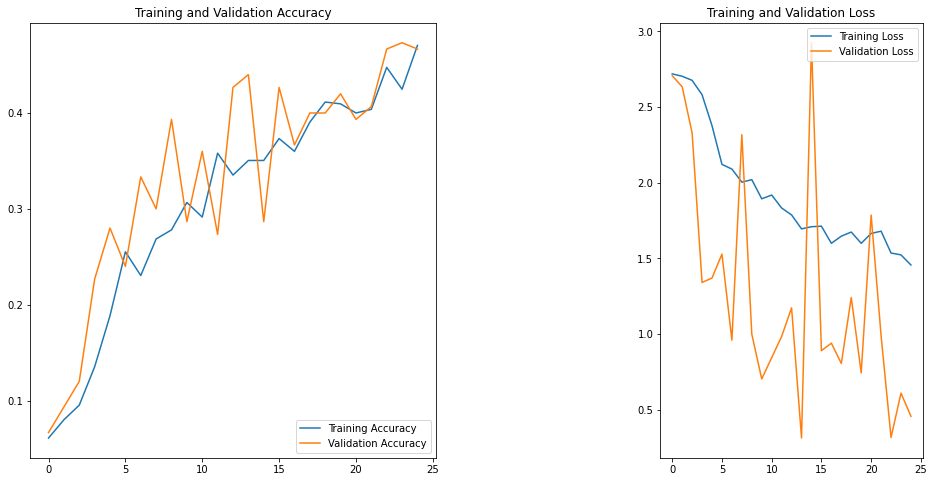

[0.4565650224685669, 0.46666666865348816]

In [0]:
BATCH_SIZE = 32
IMG_SHAPE  = 32 
EPOCHS = 25

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        shuffle=True,
                                                                        target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                        batch_size = BATCH_SIZE) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       #class_mode='binary',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                     brightness_range=(.2,1),
                                     shear_range=0.2,
                                     channel_shift_range=128,
                                     rotation_range=45,
                                     vertical_flip=True,
                                     zoom_range=0.5,).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          #class_mode='binary',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)

model1 = models.Sequential(name='model1')

model1.add(layers.Conv2D(768, (3,3), activation='relu',input_shape=(IMG_SHAPE ,IMG_SHAPE,  3)))
model1.add(layers.MaxPooling2D((3, 3)))

model1.add(layers.Conv2D(1024, (3,3), activation='relu', padding="same"))
model1.add(layers.MaxPooling2D((3, 3)))

model1.add(layers.Conv2D(512, (3,3), activation='relu', padding="same"))
model1.add(layers.MaxPooling2D((3, 3)))

model1.add(layers.Conv2D(256, (3,3), activation='relu', padding="same"))
#model1.add(layers.MaxPooling2D((3, 3))) 

model1.add(layers.Flatten())
model1.add(layers.Dense(15, activation='softmax'))

model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model1.summary()

checkpoint = ModelCheckpoint("/content/drive/My Drive/RxID/RxID15/Models/RxID15{}.h5".format(model1.name), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model1.fit(train_generator,
                    epochs=EPOCHS,
                    #batch_size=32,
                    #validation_split= 0.1,
                    validation_data=val_generator,
                     callbacks=[checkpoint,early],
                    verbose=1)

model1_train_results = model1.evaluate(train_generator)
model1_val_results = model1.evaluate(val_generator)
model1_val_results
#model.predict_classes(val_images)

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('/content/drive/My Drive/RxID/RxID15/Model Images/{}-AccLoss.png'.format(model1.name))
plt.show()
model1_val_results

## model2 - Acc: 0.44

Found 74 images belonging to 15 classes.
Found 150 images belonging to 15 classes.
Found 525 images belonging to 15 classes.
Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 768)       21504     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 768)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 1024)      7078912   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 1024)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 512)         4719104   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 512)         0         
_

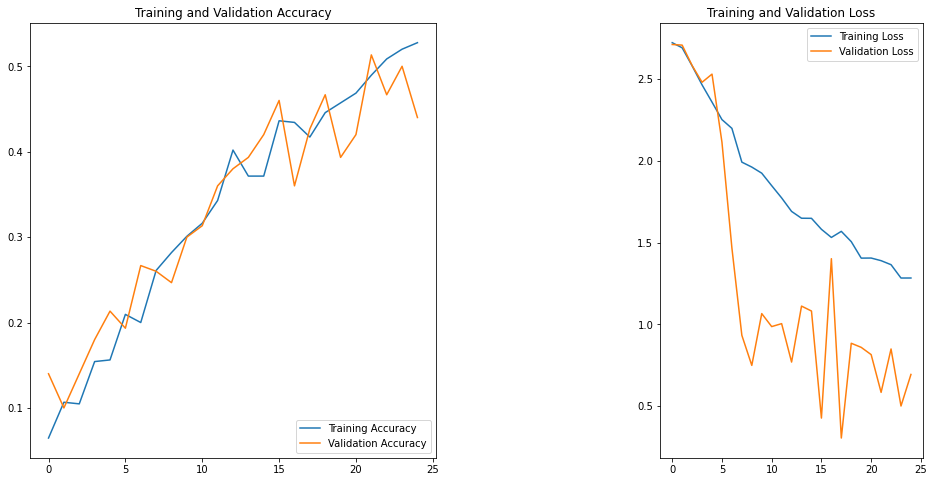

[0.694034218788147, 0.4399999976158142]

In [0]:
BATCH_SIZE = 32
IMG_SHAPE  = 48 
EPOCHS = 25
plottrain = True


test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        shuffle=True,
                                                                        target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                        batch_size = BATCH_SIZE) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       #class_mode='binary',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                     brightness_range=(.2,1),
                                     shear_range=0.2,
                                     channel_shift_range=128,
                                     rotation_range=45,
                                     vertical_flip=True,
                                     zoom_range=0.5,).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          #class_mode='binary',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)

model2 = models.Sequential(name='model2')

model2.add(layers.Conv2D(768, (3,3), activation='relu',input_shape=(IMG_SHAPE ,IMG_SHAPE,  3)))
model2.add(layers.MaxPooling2D((3, 3)))

model2.add(layers.Conv2D(1024, (3,3), activation='relu', padding="same"))
model2.add(layers.MaxPooling2D((3, 3)))
#model2.add(layers.Dropout(0.05)

model2.add(layers.Conv2D(512, (3,3), activation='relu', padding="same"))
model2.add(layers.MaxPooling2D((3, 3)))

model2.add(layers.Conv2D(256, (3,3), activation='relu', padding="same"))
#model2.add(layers.MaxPooling2D((3, 3))) 

model2.add(layers.Flatten())
model2.add(layers.Dense(15, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model2.summary()

checkpoint = ModelCheckpoint("/content/drive/My Drive/RxID/RxID15/Models/RxID15{}.h5".format(model2.name), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model2.fit(train_generator,
                    epochs=EPOCHS,
                    #batch_size=32,
                    #validation_split= 0.1,
                    validation_data=val_generator,
                     callbacks=[checkpoint,early],
                    verbose=1)

results_train1 = model2.evaluate(train_generator)
model2_val_results = model2.evaluate(val_generator)
model2_val_results
#model.predict_classes(val_images)

if plottrain == True:
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 3, 3)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('./foo.png')
  plt.show()
model2_val_results

In [0]:
model2.predict(test_images[:1])

array([[8.9223413e-08, 9.9975592e-01, 1.5309214e-06, 2.2928591e-04,
        1.3173030e-05, 9.1070079e-10, 2.4662183e-10, 1.4682051e-08]],
      dtype=float32)

In [0]:
model2.predict_classes(test_images[:5])

array([1, 4, 5, 5, 0, 0, 4, 6, 0, 0, 0, 0, 3, 1, 5, 1, 0, 4, 1, 5, 1, 2,
       0, 6, 7, 3, 5, 2, 4, 5, 2, 0, 1, 7, 1, 5, 0, 5, 1, 5, 7, 2, 6, 5,
       7, 6, 6, 3, 6, 2, 3, 6, 6, 7, 7, 2, 2, 7])

In [0]:
test_labels[0]

array([0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

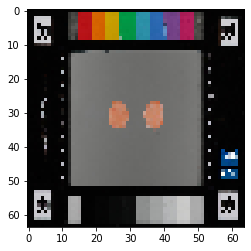

In [0]:
plt.imshow(test_images[:1][0])

## model3 - Acc: 0.58

In [0]:
BATCH_SIZE = 32
IMG_SHAPE  = 32 
EPOCHS = 50
plottrain = True


test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        shuffle=True,
                                                                        target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                        batch_size = BATCH_SIZE) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       #class_mode='binary',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                     brightness_range=(.2,1),
                                     shear_range=0.2,
                                     channel_shift_range=128,
                                     rotation_range=45,
                                     vertical_flip=True,
                                     zoom_range=0.5,).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          #class_mode='binary',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)
# model3 = VGG16(weights='imagenet', include_top=False,input_shape=(IMG_SHAPE ,IMG_SHAPE,  3))
# model3.layers.pop()
# model3 = Model(inputs=model3.inputs, outputs=model3.layers[-1].output)

model3 = models.Sequential(name='CNN 4')

model3.add(layers.Conv2D(768, (3,3), activation='relu',input_shape=(IMG_SHAPE ,IMG_SHAPE,  3)))
model3.add(layers.MaxPooling2D((3, 3)))


model3.add(layers.Conv2D(1024, (3,3), activation='relu', padding="same"))
model3.add(layers.MaxPooling2D((3, 3)))
model3.add(layers.Dropout(0.05))

model3.add(layers.Conv2D(512, (3,3), activation='relu', padding="same"))
model3.add(layers.MaxPooling2D((3, 3)))

model3.add(layers.Conv2D(256, (3,3), activation='relu', padding="same"))
#model3.add(layers.MaxPooling2D((3, 3))) 

model3.add(layers.Flatten())
model3.add(layers.Dense(15, activation='softmax'))

# learning

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model3.summary()

checkpoint = ModelCheckpoint("/content/drive/My Drive/RxID/RxID15/Models/RxID15{}.h5".format(model3.name), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model3.fit(train_generator,
                    epochs=EPOCHS,
                    #batch_size=32,
                    #validation_split= 0.1,
                    validation_data=val_generator,
                     callbacks=[checkpoint,early],
                    verbose=1)

results_train1 = model3.evaluate(train_generator)
model3_val_results = model3.evaluate(val_generator)
model3_val_results
#model.predict_classes(val_images)

if plottrain == True:
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 3, 3)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('/content/drive/My Drive/RxID/RxID15/Model Images/{}-Acc_Loss.png'.format(model3.name))
  plt.show()
model3_val_results

NameError: ignored

---

## model4 - Acc: 0.65

- dropout
- 100 epochs

In [0]:
BATCH_SIZE = 32
IMG_SHAPE  = 32 
EPOCHS = 100
plottrain = True


test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        shuffle=True,
                                                                        target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                        batch_size = BATCH_SIZE) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       #class_mode='binary',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                     brightness_range=(.2,1),
                                     shear_range=0.2,
                                     channel_shift_range=128,
                                     rotation_range=45,
                                     vertical_flip=True,
                                     zoom_range=0.5,).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          #class_mode='binary',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)
# model4 = VGG16(weights='imagenet', include_top=False,input_shape=(IMG_SHAPE ,IMG_SHAPE,  3))
# model4.layers.pop()
# model4 = Model(inputs=model4.inputs, outputs=model4.layers[-1].output)

model4 = models.Sequential(name='CNN 4')

model4.add(layers.Conv2D(768, (3,3), activation='relu',input_shape=(IMG_SHAPE ,IMG_SHAPE,  3)))
model4.add(layers.MaxPooling2D((3, 3)))


model4.add(layers.Conv2D(1024, (3,3), activation='relu', padding="same"))
model4.add(layers.MaxPooling2D((3, 3)))
model4.add(layers.Dropout(0.05))

model4.add(layers.Conv2D(512, (3,3), activation='relu', padding="same"))
model4.add(layers.MaxPooling2D((3, 3)))

model4.add(layers.Conv2D(256, (3,3), activation='relu', padding="same"))
#model4.add(layers.MaxPooling2D((3, 3))) 

model4.add(layers.Flatten())
model4.add(layers.Dense(15, activation='softmax'))

# learning

model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model4.summary()

checkpoint = ModelCheckpoint("/content/drive/My Drive/RxID/RxID15/Models/RxID15{}.h5".format(model4.name), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model4.fit(train_generator,
                    epochs=EPOCHS,
                    #batch_size=32,
                    #validation_split= 0.1,
                    validation_data=val_generator,
                     callbacks=[checkpoint,early],
                    verbose=1)

results_train1 = model4.evaluate(train_generator)
model4_val_results = model4.evaluate(val_generator)
model4_val_results
#model.predict_classes(val_images)

if plottrain == True:
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 3, 3)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('/content/drive/My Drive/RxID/RxID15/Model Images/{}-Acc_Loss.png'.format(model4.name))
  plt.show()
model4_val_results

Model: "CNN 4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 768)       21504     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 768)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 1024)      7078912   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 1024)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1024)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 512)         4719104   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 512)         0     

In [0]:
model5.load_weights('/content/drive/My Drive/RxID/RxID15/Models/RxID15CNN 4.h5')
model5.summary()
model_4_val_results = model5.evaluate(val_generator)
model_4_val_results

Model: "CNN 4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 768)       21504     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 768)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 1024)      7078912   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 1024)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1024)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 512)         4719104   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 512)         0     

[0.1257256716489792, 0.6600000262260437]

In [0]:
class_keys = list(train_generator.class_indices.keys())
class_values = list(train_generator.class_indices.values())

In [0]:
class_keys[class_values.index(0)]

'00006074554'

## model5 - ...


- dropout
- 150 epochs

In [0]:
BATCH_SIZE = 32
IMG_SHAPE  = 32 
EPOCHS = 250
plottrain = True


test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        shuffle=True,
                                                                        target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                        batch_size = BATCH_SIZE) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       #class_mode='binary',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                     brightness_range=(.2,1),
                                     shear_range=0.2,
                                     channel_shift_range=128,
                                     rotation_range=45,
                                     vertical_flip=True,
                                     zoom_range=0.5,).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          #class_mode='binary',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)
# model5 = VGG16(weights='imagenet', include_top=False,input_shape=(IMG_SHAPE ,IMG_SHAPE,  3))
# model5.layers.pop()
# model5 = Model(inputs=model5.inputs, outputs=model5.layers[-1].output)

model5 = models.Sequential(name='CNN 4')

model5.add(layers.Conv2D(768, (3,3), activation='relu',input_shape=(IMG_SHAPE ,IMG_SHAPE,  3)))
model5.add(layers.MaxPooling2D((3, 3)))


model5.add(layers.Conv2D(1024, (3,3), activation='relu', padding="same"))
model5.add(layers.MaxPooling2D((3, 3)))
model5.add(layers.Dropout(0.05))

model5.add(layers.Conv2D(512, (3,3), activation='relu', padding="same"))
model5.add(layers.MaxPooling2D((3, 3)))

model5.add(layers.Conv2D(256, (3,3), activation='relu', padding="same"))
#model5.add(layers.MaxPooling2D((3, 3))) 

model5.add(layers.Flatten())
model5.add(layers.Dense(15, activation='softmax'))

# learning

model5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model5.summary()

checkpoint = ModelCheckpoint("/content/drive/My Drive/RxID/RxID15/Models/RxID15{}.h5".format(model4.name), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model4.fit(train_generator,
                    epochs=EPOCHS,
                    #batch_size=32,
                    #validation_split= 0.1,
                    validation_data=val_generator,
                     callbacks=[checkpoint,early],
                    verbose=1)

results_train1 = model5.evaluate(train_generator)
model5_val_results = model5.evaluate(val_generator)
model5_val_results
#model.predict_classes(val_images)

if plottrain == True:
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 3, 3)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('/content/drive/My Drive/RxID/RxID15/Model Images/{}-Acc_Loss.png'.format(model5.name))
  plt.show()
model5_val_results

## model6 - Acc: 0.58

In [0]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        shuffle=True,
                                                                        target_size=(IMG_SHAPE,IMG_SHAPE))

Found 74 images belonging to 15 classes.


Found 74 images belonging to 15 classes.
Found 150 images belonging to 15 classes.
Found 525 images belonging to 15 classes.
Model: "CNN 4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 34, 34, 768)       21504     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 768)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 1024)      7078912   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 1024)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1024)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 512)         4719104   
__

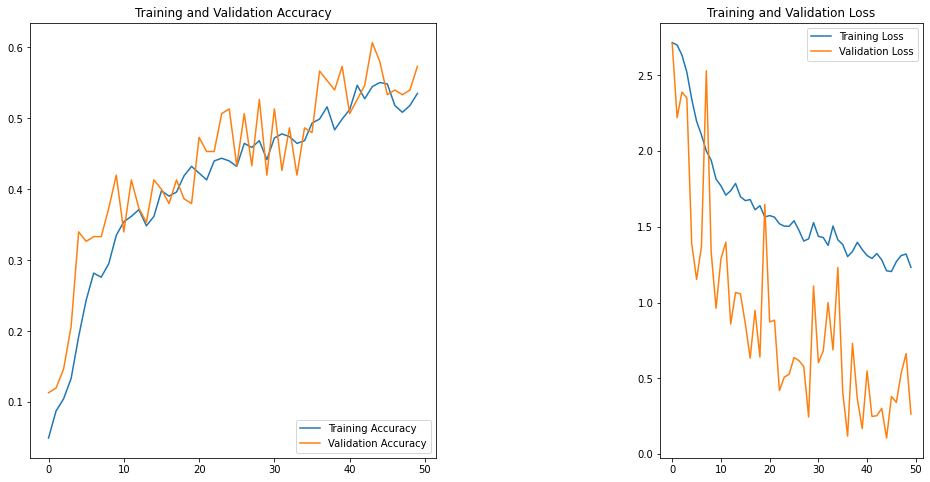

[0.26507696509361267, 0.5733333230018616]

In [0]:
BATCH_SIZE = 32
IMG_SHAPE  = 36 
EPOCHS = 100
plottrain = True


test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        shuffle=True,
                                                                        target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                        #batch_size = BATCH_SIZE) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       #class_mode='binary',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                     brightness_range=(.2,1),
                                     shear_range=0.2,
                                     channel_shift_range=128,
                                     rotation_range=45,
                                     vertical_flip=True,
                                     zoom_range=0.5,).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          #class_mode='binary',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)
# model6 = VGG16(weights='imagenet', include_top=False,input_shape=(IMG_SHAPE ,IMG_SHAPE,  3))
# model6.layers.pop()
# model6 = Model(inputs=model6.inputs, outputs=model6.layers[-1].output)

model6 = models.Sequential(name='model6')

model6.add(layers.Conv2D(768, (3,3), activation='relu',input_shape=(IMG_SHAPE ,IMG_SHAPE,  3)))
model6.add(layers.MaxPooling2D((3, 3)))

model6.add(layers.Conv2D(1024, (3,3), activation='relu', padding="same"))
model6.add(layers.MaxPooling2D((3, 3)))
model6.add(layers.Dropout(0.05))

model6.add(layers.Conv2D(512, (3,3), activation='relu', padding="same"))
model6.add(layers.MaxPooling2D((3, 3)))

model6.add(layers.Conv2D(256, (3,3), activation='relu', padding="same"))
#model6.add(layers.MaxPooling2D((3, 3))) 

model6.add(layers.Flatten())
model6.add(layers.Dense(15, activation='softmax'))

model6.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model6.summary()

checkpoint = ModelCheckpoint("/content/drive/My Drive/RxID/RxID15/Models/RxID15{}.h5".format(model4.name), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model4.fit(train_generator,
                    epochs=EPOCHS,
                    #batch_size=32,
                    #validation_split= 0.1,
                    validation_data=val_generator,
                     callbacks=[checkpoint,early],
                    verbose=1)

results_train1 = model6.evaluate(train_generator)
model6_val_results = model6.evaluate(val_generator)
model6_val_results
#model.predict_classes(val_images)

if plottrain == True:
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 3, 3)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  #plt.savefig('./foo.png')
  plt.show()
model6_val_results

In [0]:
model4.predict_generator(test_generator,10)[:5]

array([[1.5603587e-01, 1.3551349e-04, 9.0713213e-05, 8.9450151e-02,
        3.3724788e-04, 1.9175600e-01, 9.2876321e-03, 3.6157876e-01,
        1.1475331e-04, 7.0058599e-02, 9.2301272e-02, 5.1353173e-04,
        2.7433937e-02, 3.9138136e-05, 8.6686132e-04],
       [1.2499259e-09, 3.4617544e-05, 5.2671645e-09, 4.4543671e-05,
        4.2752055e-07, 7.1680397e-01, 2.1699364e-01, 4.9954217e-08,
        6.4434238e-02, 1.9503043e-04, 2.0082622e-10, 1.2558334e-03,
        8.7603396e-05, 1.3863835e-10, 1.4999064e-04],
       [1.0535298e-11, 9.8759544e-19, 8.3027976e-17, 5.8028089e-11,
        8.6178517e-01, 5.6092631e-12, 1.1231292e-11, 2.2120450e-12,
        1.7435057e-15, 1.3620343e-09, 1.5526190e-10, 7.7676678e-11,
        1.3388103e-08, 1.2064401e-09, 1.3821489e-01],
       [1.1483950e-06, 5.3155227e-11, 4.7285376e-10, 1.6375064e-09,
        4.0813600e-05, 4.1771662e-09, 6.3269066e-09, 1.9558092e-07,
        3.3644291e-08, 2.8014643e-10, 3.6251902e-05, 2.3909703e-09,
        1.6596490e-05,

In [0]:
model4.

In [0]:
model4.predict_classes(test_generator)

ValueError: ignored

In [0]:
test_labels[0]

array([0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

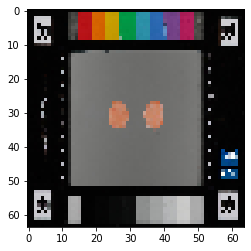

In [0]:
plt.imshow(test_images[:1][0])

In [0]:
test_images[:1]

NameError: ignored

In [0]:
tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [0]:
tf.math.confusion_matrix(
    val_labels[:5][1], 
    model2.predict_classes(test_images[:5]), 
    num_classes=8, weights=None, dtype=tf.dtypes.int32,
    #name=None
)

InvalidArgumentError: ignored

## model5

In [0]:
model3 = models.Sequential(name='CNN 3HL(1024/512/256/512)-5Ep-TL=False')

model3.add(layers.Conv2D(2048, (3, 3), activation='relu',input_shape=(256 ,256,  3)))
model3.add(layers.MaxPooling2D((2,2)))

model3.add(layers.Conv2D(1024, (3, 3), activation='relu', padding="same"))
model3.add(layers.MaxPooling2D((2,2)))

model3.add(layers.Conv2D(512, (3, 3), activation='relu', padding="same"))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(512, (3, 3), activation='relu', padding="same"))
model3.add(layers.MaxPooling2D((2, 2))) 

model3.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
model3.add(layers.MaxPooling2D((2, 2))) 


model3.add(layers.Flatten())
model3.add(layers.Dense(11, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model3.summary()

checkpoint = ModelCheckpoint("/content/drive/My Drive/RxID/RxID15/Models/RxID15{}.h5".format(model4.name), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model4.fit(train_generator,
                    epochs=EPOCHS,
                    #batch_size=32,
                    #validation_split= 0.1,
                    validation_data=val_generator,
                     callbacks=[checkpoint,early],
                    verbose=1)

results_train = model3.evaluate(train_images, train_labels)
model3_val_results = model3.evaluate(val_images, val_labels)

results_train

model3_val_results

#model.predict_classes(val_images)

## model6

In [0]:
model4 = models.Sequential(name='CNN 3HL(1024/512/256/512)-5Ep-TL=False')

model4.add(layers.Conv2D(1024, (3, 3), activation='relu',input_shape=(64 ,64,  3)))
model4.add(layers.MaxPooling2D((2,2)))

model4.add(layers.Conv2D(2048, (3, 3), activation='relu', padding="same"))
model4.add(layers.MaxPooling2D((2,2)))

model4.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(512, (3, 3), activation='relu', padding="same"))
model4.add(layers.MaxPooling2D((2, 2))) 


model4.add(layers.Flatten())
model4.add(layers.Dense(11, activation='softmax'))

model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model4.summary()

checkpoint = ModelCheckpoint("/content/drive/My Drive/RxID/RxID15/Models/RxID15{}.h5".format(model4.name), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model4.fit(train_generator,
                    epochs=EPOCHS,
                    #batch_size=32,
                    #validation_split= 0.1,
                    validation_data=val_generator,
                     callbacks=[checkpoint,early],
                    verbose=1)

results_train4 = model4.evaluate(train_images, train_labels)
results_test4 = model4.evaluate(val_images, val_labels)

results_train

results_test

#model.predict_classes(val_images)

Model: "CNN 3HL(1024/512/256/512)-5Ep-TL=False"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 62, 62, 1024)      28672     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 31, 31, 1024)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 31, 31, 2048)      18876416  
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 15, 15, 2048)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 15, 15, 256)       4718848   
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_28 (Conv2D)          

---